In [1]:
%matplotlib inline

import os
import glob
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
adata_file = '/home/ngr4/project/collabs/grants/czi_rp_2103/data/rpczi_cpb.h5ad'
pfp = '/home/ngr4/project/collabs/grants/czi_rp_2103/results/'
adata = sc.read(adata_file)
adata.obs.head()

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito
AAACCCATCACAAGAA-1-CPB3,CPB3,506,6.228511,989.0,6.897705,47.118301,57.937310,69.059656,99.393327,0.016178
AAACGAATCCGATCGG-1-CPB3,CPB3,826,6.717805,1468.0,7.292337,35.286104,44.618529,57.356948,77.792916,0.078338
AAACGCTAGTTCATCG-1-CPB3,CPB3,528,6.270988,971.0,6.879356,41.091658,52.317199,66.220391,97.116375,0.018538
AAACGCTCAAGGCGTA-1-CPB3,CPB3,477,6.169611,850.0,6.746412,41.176471,53.882353,67.411765,100.000000,0.043529
AAACGCTTCGGACCAC-1-CPB3,CPB3,1448,7.278629,3554.0,8.176110,36.662915,45.835678,56.387169,73.325830,0.016882


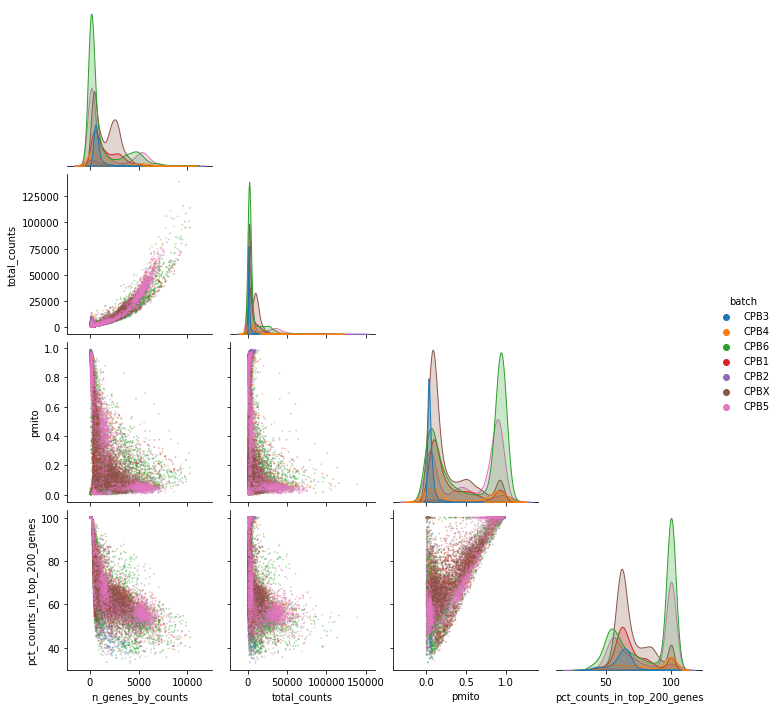

In [3]:
varsoi = ['n_genes_by_counts', 'total_counts', 'pmito', 'pct_counts_in_top_200_genes']
p = sns.pairplot(adata.obs, hue='batch', 
                 vars=varsoi,
                 plot_kws={'alpha':0.4, 'linewidth':0, 's':3, 'rasterized':True},
                 corner=True)
p.savefig(os.path.join(pfp, 'pre-pp_qc.png'), dpi=300)

In [4]:
dt = adata.obs.loc[:, ['batch']+varsoi].groupby('batch').describe()
dt.loc[:, [(i, j) for i,j in dt.columns if j in ['count', 'mean', 'std']]]

n_genes_by_counts                           total_counts                \
                  count         mean          std        count          mean   
batch                                                                          
CPB3             1104.0   848.150362   678.190035       1104.0   1791.117798   
CPB4             1091.0  1529.733272  2125.992768       1091.0  10649.195312   
CPB6             7583.0  1261.061717  1918.870105       7583.0   6906.421387   
CPB1             2856.0  1629.031162  1486.168216       2856.0   6877.451172   
CPB2              472.0  1079.701271  1949.982438        472.0   8430.171875   
CPBX             5871.0  1682.513030  1208.441921       5871.0   6989.625000   
CPB5             4909.0  1547.463842  2119.726647       4909.0   9383.205078   

                      pmito                     pct_counts_in_top_200_genes  \
                std   count      mean       std                       count   
batch                                                                         
CPB3    1867.460571  1104.0  0.048168  0.045558                      1104.0   
CPB4   15570.947266  1091.0  0.433584  0.400325                      1091.0   
CPB6   11465.859375  7583.0  0.585235  0.397990                      7583.0   
CPB1    9047.518555  2856.0  0.285204  0.277105                      2856.0   
CPB2   16711.312500   472.0  0.683720  0.380977                       472.0   
CPBX    6383.262207  5871.0  0.257455  0.267273                      5871.0   
CPB5   14905.981445  4909.0  0.564695  0.371882                      4909.0   

                             
            mean        std  
batch                        
CPB3   62.345454   9.677181  
CPB4   80.803642  18.982102  
CPB6   83.120717  20.871668  
CPB1   69.588715  13.728204  
CPB2   85.592900  20.788136  
CPBX   70.058927  13.212718  
CPB5   82.422859  20.389371

In [5]:
# filter, norm, transform
adata = adata[adata.obs['pmito'] <= 0.2, :]
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) # filtering cells gets rid of some genes of interest
adata.raw = adata
sc.pp.normalize_total(adata)
sc.pp.sqrt(adata)

if True:
    # save
    adata.write('/home/ngr4/project/collabs/grants/czi_rp_2103/data/processed/rpczi_cpb.h5ad')

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


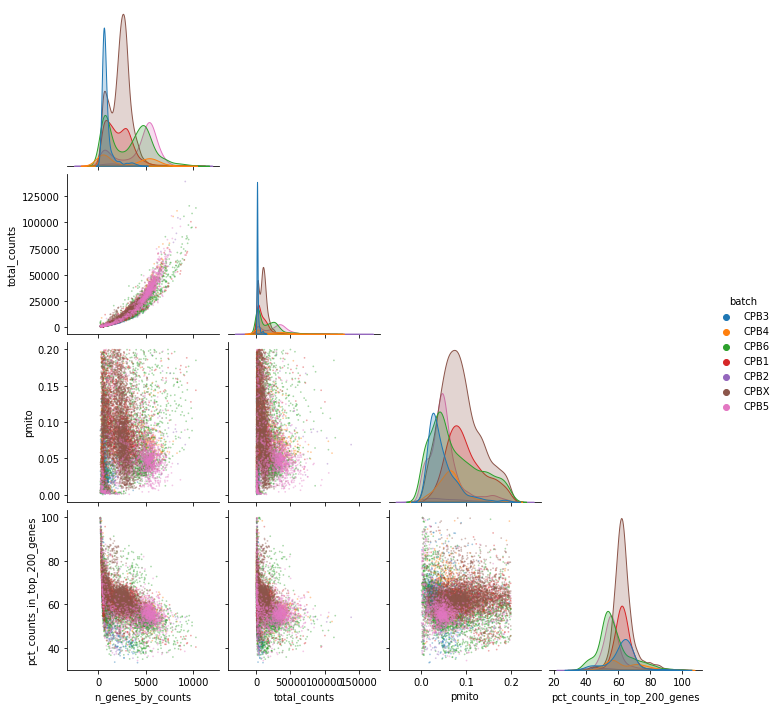

In [12]:
varsoi = ['n_genes_by_counts', 'total_counts', 'pmito', 'pct_counts_in_top_200_genes']
p = sns.pairplot(adata.obs, hue='batch', 
                 vars=varsoi,
                 plot_kws={'alpha':0.4, 'linewidth':0, 's':3, 'rasterized':True},
                 corner=True)
p.savefig(os.path.join(pfp, 'post-pp_qc.png'), dpi=300)

In [7]:
dt = adata.obs.loc[:, ['batch']+varsoi].groupby('batch').describe()
dt.loc[:, [(i, j) for i,j in dt.columns if j in ['count', 'mean', 'std']]]

n_genes_by_counts                           total_counts                \
                  count         mean          std        count          mean   
batch                                                                          
CPB3             1082.0   858.264325   680.875770       1082.0   1810.328979   
CPB4              485.0  2838.892784  2436.470838        485.0  18174.541016   
CPB6             2255.0  3177.737916  2199.499645       2255.0  16377.298828   
CPB1             1649.0  2148.226198  1426.063819       1649.0   9178.269531   
CPB2              105.0  2650.638095  2412.226753        105.0  15788.428711   
CPBX             3684.0  2247.842291  1047.763874       3684.0   9502.071289   
CPB5             1452.0  4230.820937  1986.942595       1452.0  26672.287109   

                      pmito                     pct_counts_in_top_200_genes  \
                std   count      mean       std                       count   
batch                                                                         
CPB3    1880.949341  1082.0  0.044928  0.032540                      1082.0   
CPB4   20181.902344   485.0  0.064719  0.032508                       485.0   
CPB6   16444.017578  2255.0  0.074205  0.053434                      2255.0   
CPB1    9874.318359  1649.0  0.097368  0.041205                      1649.0   
CPB2   27217.322266   105.0  0.060459  0.049445                       105.0   
CPBX    6494.481934  3684.0  0.087157  0.043427                      3684.0   
CPB5   17779.242188  1452.0  0.051798  0.036258                      1452.0   

                             
            mean        std  
batch                        
CPB3   61.987387   9.177662  
CPB4   63.653630  10.636511  
CPB6   57.305027  10.449054  
CPB1   62.172732   6.054075  
CPB2   54.060303  11.780053  
CPBX   63.135010   6.605463  
CPB5   56.952498   8.358620